GravLensing Project code compilation

In [1]:
from astropy.io import fits
from astropy.utils.data import get_pkg_data_filename

import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torchvision import datasets, transforms


new Dataset class:

In [2]:
class DatasetFolder:
    def __init__(self, root_dir, transforms=None):
        self.root_dir=root_dir
        self.transforms=transforms
    def __len__(self):
        return len(os.listdir(self.root_dir))
    def __getitem__(self,index):
        label=os.listdir(self.root_dir)[index]
        fits_path=r''+self.root_dir+'/'+label
        file=fits.getdata(fits_path, ext=0)
        file=file.astype(float)
        if self.transforms:
            file=self.transforms(file)
        return (file, label)

Initialisation of data:

['lens_1', 'lens_2', 'lens_3', 'lens_4', 'lens_5']
[<__main__.DatasetFolder object at 0x000001FC9D44DA60>, <__main__.DatasetFolder object at 0x000001FC93EF3E80>, <__main__.DatasetFolder object at 0x000001FC9D1A1370>, <__main__.DatasetFolder object at 0x000001FC93F394C0>, <__main__.DatasetFolder object at 0x000001FC9D1954F0>]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


680


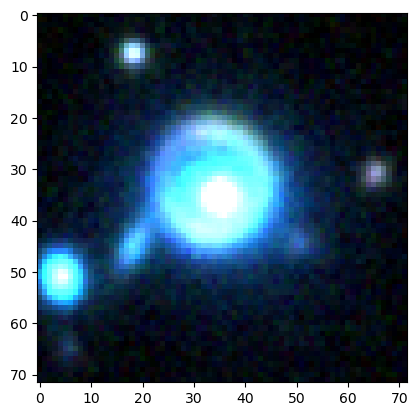

In [6]:
class Initialisation:
    #main for excluding runtime errors in windows
    def main():
        #creating relative path to data for use on different devices
        filedir=r'C:/Users/sonya/gravLensing/gravlensing_sonya.francisco/tum_project/lens'
        filename1=os.listdir(filedir)
        print(filename1) #gives the filenames lens_1 etc.

        #lenses contains the subfiles of type Datasetfolder
        lenses = []

        #transforms used on the images
        #transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0,0,0),(1,1,1))])
        #doesn't work yet!

        for filename in filename1:
            filedir2=r''+filedir+'/'+filename
            filename2=os.listdir(filedir2)
            data=DatasetFolder(filedir2, None)
            lenses.append(data)
        print(lenses)

        #concat all the lenses into one dataset
        image_dataset = torch.utils.data.ConcatDataset(lenses)

        #trainloader
        trainloader = torch.utils.data.DataLoader(image_dataset, batch_size=64, shuffle=True)
       
        #iterate over trainloader
        target=next(iter(trainloader))
        print(len(trainloader))
        
        #show images
        fig=plt.figure()
        imageRGB_reshape = np.einsum('kij->ijk',target[0][1])
        plt.imshow(imageRGB_reshape)
        plt.show()
        
    if __name__=='__main__':
        main() 
    

Creating the model of the Network Net

In [7]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # 3 input image channel (I,R,B), 6 output channels, 3x3 square convolution
        #16 layers of convolution followed by a fully connected linear and an output layer

        self.conv11 = nn.Conv2d(3, 6, 3)
        self.conv12 = nn.Conv2d(6, 16, 3)

        self.conv21 = nn.Conv2d(1, 6, 3)
        self.conv22 = nn.Conv2d(6, 16, 3)

        self.conv31 = nn.Conv2d(1, 6, 3)
        self.conv32 = nn.Conv2d(6, 16, 3)

        self.conv41 = nn.Conv2d(16, 16, 3)
        self.conv42 = nn.Conv2d(16, 16, 3)

        self.conv51 = nn.Conv2d(16, 16, 3)
        self.conv52 = nn.Conv2d(16, 16, 3)

        self.conv61 = nn.Conv2d(16, 16, 3)
        self.conv62 = nn.Conv2d(16, 16, 3)

        self.conv71 = nn.Conv2d(16, 16, 3)
        self.conv72 = nn.Conv2d(16, 16, 3)

        self.conv81 = nn.Conv2d(16, 16, 3)
        self.conv82 = nn.Conv2d(16, 16, 3)

        self.fc1 = nn.Linear(16 * 72 * 72, 16)  # 6*6 from image dimension
        self.fc2 = nn.Linear(16, 1)

    def forward(self, x):
        # ReLu convolution over a (2, 2) window
        x = F.relu(self.conv11(x), (2, 2))
        x = F.relu(self.conv12(x), (2, 2))
        x = F.relu(self.conv21(x), (2, 2))
        x = F.relu(self.conv22(x), (2, 2))
        x = F.relu(self.conv31(x), (2, 2))
        x = F.relu(self.conv32(x), (2, 2))
        x = F.relu(self.conv41(x), (2, 2))
        x = F.relu(self.conv42(x), (2, 2))
        x = F.relu(self.conv51(x), (2, 2))
        x = F.relu(self.conv52(x), (2, 2))
        x = F.relu(self.conv61(x), (2, 2))
        x = F.relu(self.conv62(x), (2, 2))
        x = F.relu(self.conv71(x), (2, 2))
        x = F.relu(self.conv72(x), (2, 2))
        x = F.relu(self.conv81(x), (2, 2))
        x = F.relu(self.conv82(x), (2, 2))
    
        #x = x.view(-1, self.num_flat_features(x)) ---> what is this?
        #final fully connected linear layers with ReLu and sigmoid
        x = F.relu(self.fc1(x))
        x = F.sigmoid(self.fc2(x))
        x = self.fc1(x)
        x = self.fc2(x)
        return x

    #no idea what this does...
    '''
    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features'''
#creating the model on device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")
model=Net().to(device)
print(model)

Using cpu device
Net(
  (conv11): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv12): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv21): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv22): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv31): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv32): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv41): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv42): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv51): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv52): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv61): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv62): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv71): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv72): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv81): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv82): Conv2d(16, 16, kernel_size=(3, 3), stride=(1,